<center> <h1> Jamboree Day: Generate a general report of JUMP metadata </h1> </center>

3 questions will be answered in this notebook: 
1) How many different MoAs / Target are available?
2) Do we have more perturbations per MoAs or targets?
3) What are the distribution of MoAs / targets

For this notebook:
+ **moa annotation available** in the [broadinstitute/repurposing](https://repo-hub.broadinstitute.org/repurposing#download-data) has been used. 
+ **target annotation available** used in Johns Paper and available [here](https://cellpainting-gallery.s3.amazonaws.com/index.html#cpg0034-arevalo-su-motive/broad/workspace/publication_data/2024_MOTIVE/inputs/annotations/) has been used. 

In [266]:
import polars as pl
from data_v2 import get_table
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# a) Load Table

In [150]:
compound = get_table("compound")
well = get_table("well")
plate = get_table("plate")
micro = get_table("microscope_config")
moa = pl.read_csv("https://s3.amazonaws.com/data.clue.io/repurposing/downloads/repurposing_drugs_20200324.txt",
            separator="\t",
            comment_prefix="!")

pert_iname = pl.read_csv("https://storage.googleapis.com/cdot-general-storage/repurposing_samples_20240610.txt",
            separator="\t",
            comment_prefix="!")


target = pl.read_parquet(("https://cellpainting-gallery.s3.amazonaws.com/cpg0034-arevalo-su-motive/"
"broad/workspace/publication_data/2024_MOTIVE/inputs/annotations/compound_gene.parquet"))

In [151]:
plate = plate.select(pl.all().exclude("Metadata_Source"))
micro_features = ['Metadata_Source','Metadata_Microscope_Name',
                  'Metadata_Widefield_vs_Confocal',
                  'Metadata_Excitation_Type',
                  'Metadata_Objective_NA',
                  'Metadata_Filter_Configuration']
micro = micro.with_columns(
    ("source_" + pl.col("Metadata_Source").cast(str)).alias("Metadata_Source")).select(
    pl.col(micro_features))

compound_merge = (compound.join(well, on=pl.col("Metadata_JCP2022"), how="inner")
.join(plate, on=pl.col("Metadata_Plate"), how="inner")
.join(micro, on=pl.col("Metadata_Source"), how="inner"))

# b) Preprocessing Table

In [152]:
# Filtering inchikey and tarket only, and then group target by inchikey whil separating them with '|'
target = (target.select(pl.col("inchikey", "target")).drop_nulls()
 .group_by("inchikey").agg(pl.col("target").unique())
 .with_columns(pl.col("target").list.sort().list.join("|")))

In [153]:
# Retrieve the InChIKey infor for each moa using pert_iname
moa = (moa.select(pl.col("pert_iname", "moa")).unique().drop_nulls()
 .join(pert_iname.select(pl.col("pert_iname", "InChIKey")).unique().drop_nulls(),
      on="pert_iname",
      how="inner"))
#For each inchikey join moa and separate them with | while making sure unicity of moa inside those compose moa
moa = (moa.group_by("InChIKey").agg(pl.col("moa").unique())
 .with_columns((pl.col("moa").list.sort().list.join("|")
               .str.split("|")
               .list.unique()
               .list.sort()
               .list.join("|"))))

In [154]:
# Remove the JCP2022_99... sample. 
compound_merge = compound_merge.filter(pl.col("Metadata_JCP2022").str.contains("JCP2022_99+") != True)

In [156]:
# Merging moa
compound_moa = compound_merge.join(moa,
                   left_on="Metadata_InChIKey",
                   right_on="InChIKey",
                   how="left")
compound_target = compound_merge.join(target,
                   left_on="Metadata_InChIKey",
                   right_on="inchikey",
                   how="left")

# c) Extracting info per moa and target

In [251]:
def give_info_key(table:pl.DataFrame, key:str):
                 #number of unique key 
    stats_key = {f"unique_{key}": table.select(pl.col(key)).unique().drop_nulls().shape[0],
                 #number of unique key when unwrap (removing | )
                 f"unique_{key}_unwrap": table.select(pl.col(key).str.split("|")).explode(key).unique().drop_nulls().shape[0], 
                 #number of composed key with |
                 f"unique_{key}_composed": table.filter(pl.col(key).str.contains("\|")).select(pl.col(key).n_unique()).row(0)[0],
                 #count of compound when no info about key is available
                 f"count_compound_null_{key}": (table.select(pl.col("Metadata_InChIKey", key)).unique()
                 .filter(pl.col(key).is_null()).shape[0]),
                 #count of compound when info about key is available
                 f"count_compound_{key}": (table.select(pl.col("Metadata_InChIKey", key)).unique()
                 .filter(pl.col(key).is_null() != True).shape[0]), 
                 #count of replicates when no info about key is available
                 f"count_replicate_null_{key}": table.filter(pl.col(key).is_null()).shape[0], 
                 #count of replicates when info about key is available
                 f"count_replicate_{key}": table.filter(pl.col(key).is_null() != True).shape[0]}
    compound_count_per_key = (table.filter(pl.col(key).is_null() != True)
                             .group_by(key).agg(pl.col("Metadata_InChIKey").n_unique().alias(f"unique_compound_per_{key}"),
                                                  pl.col("Metadata_InChIKey").len().alias(f"replicate_per_{key}")))
    compound_count_per_unwrap_key = (table.filter(pl.col(key).is_null() != True)
                             .with_columns(pl.col(key).str.split("|")).explode(key)
                             .group_by(key).agg(pl.col("Metadata_InChIKey").n_unique().alias(f"unique_compound_per_unwrap_{key}"),
                                                  pl.col("Metadata_InChIKey").len().alias(f"replicate_per_unwrap_{key}")))
    return pl.DataFrame(stats_key), compound_count_per_key, compound_count_per_unwrap_key

In [252]:
stats_moa, compound_count_per_moa, compound_count_per_unwrap_moa = give_info_key(compound_moa, "moa")

In [253]:
stats_target, compound_count_per_target, compound_count_per_unwrap_target = give_info_key(compound_target, "target")

# 1&2) How many different MoAs / Target are available? More perturbations per MoAs or targets ?


| table_key | Description |
|-------------|---------|
| 'unique_moa'| number of unique key |
| 'unique_moa_unwrap' | number of unique key when unwrap (removing \| ) |
| 'unique_moa_composed'| number of composed key with \| |
| 'count_compound_null_moa'| count of compound when no info about key is available|
| 'count_compound_moa'| count of compound when info about key is available|
| 'count_replicate_null_moa'| count of replicates when no info about key is available|
| 'count_replicate_moa'| count of replicates when info about key is available|


In [345]:
total_replicate = compound_moa.shape[0]
total_replicate

908510

In [265]:
stats_moa

unique_moa,unique_moa_unwrap,unique_moa_composed,count_compound_null_moa,count_compound_moa,count_replicate_null_moa,count_replicate_moa
i64,i64,i64,i64,i64,i64,i64
703,620,127,113919,1876,836863,71647


In [255]:
stats_target

unique_target,unique_target_unwrap,unique_target_composed,count_compound_null_target,count_compound_target,count_replicate_null_target,count_replicate_target
i64,i64,i64,i64,i64,i64,i64
2591,20368,2120,112713,3082,680911,227599


Answer:
+ There is: **703** unique composed **moa** but only **620** when unwrap
+ In a similar fashion, there is **2591** composed **target** and **20368** when unwrap

+ There is: **1876** unique perturbation with **moa** information
+ There is: **3082** unique perturbation with **target** information

# 3) What are the distribution of MoAs / targets?

## a) Visualisation which might be complex to grab
But how does that transfer in term of distribution? 
Let's see the count of compound per moa/target (wrap or unwrap), and the count of replicates (or the proportion of replicate for a certain moa/target in regard of the total number of replicate) (wrap or unwrap)

Note, for each graph produced, a prior table gathering some statistics is displayed to help analyse the graph.

In [336]:
def show_key_distribution(table, total_replicate):
    group, unique, replicate = table.columns
    df = (table.sort(by=[unique, group]).with_columns(
        pl.col(replicate) / total_replicate)).to_pandas()
    
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    
    width = 0.4
    
    df[unique].plot(kind='bar', color='red', ax=ax, width=width, position=1)
    df[replicate].plot(kind='bar', color='blue', ax=ax2, width=width, position=0, logy=True)
    ax.set_xticklabels([])
    ax2.set_xticklabels([])
    ax.legend(loc=(0,0.9))
    ax2.legend(loc=(0,0.95))
    ax.set_ylabel(f'count of unique compound per {group} (red)', fontsize="x-large")
    ax2.set_ylabel('proportion of replicate (count of replicate / total) replicate in log-scale (blue)', fontsize="x-large")
    ax.set_xlabel(f'{group}', fontsize="x-large")

    plt.show()

In [337]:
compound_count_per_moa.select(pl.all().exclude("moa")).describe()

describe,unique_compound_per_moa,replicate_per_moa
str,f64,f64
"""count""",703.0,703.0
"""null_count""",0.0,0.0
"""mean""",2.668563,101.916074
"""std""",3.876618,614.031693
"""min""",1.0,4.0
"""25%""",1.0,9.0
"""50%""",1.0,14.0
"""75%""",3.0,36.0
"""max""",43.0,9859.0


#### How to interpret this graph:
For this kind of barplot: the x axis gather different moa. For the red y axis, a bar correspond to a count of unique perturbation for this related moa. In blue, a bar correspond to a proportion of replicate relative to the total number of replicate, on a log scale and this for each moa. 

It gives information on how replicate compare to the number of unique perturbation

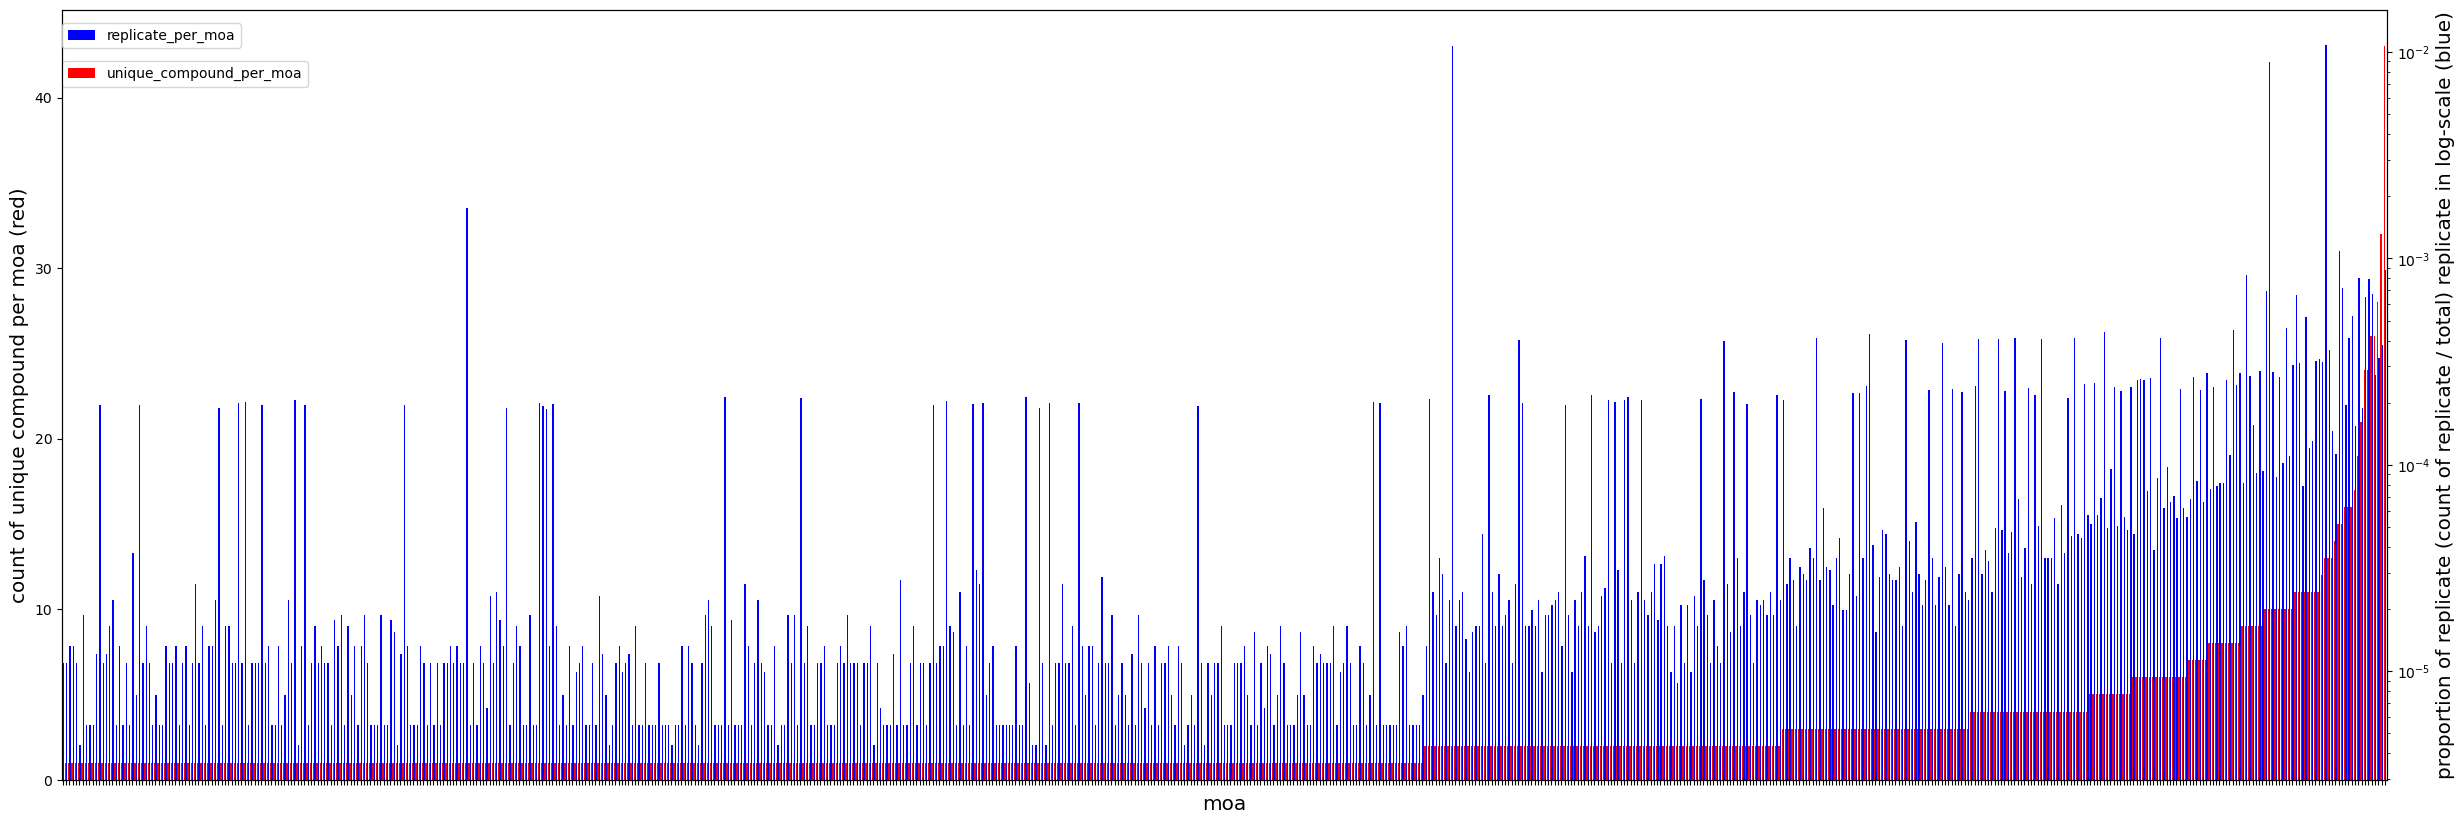

In [338]:
show_key_distribution(compound_count_per_moa, total_replicate)

In [339]:
compound_count_per_unwrap_moa.select(pl.all().exclude("moa")).describe()

describe,unique_compound_per_unwrap_moa,replicate_per_unwrap_moa
str,f64,f64
"""count""",620.0,620.0
"""null_count""",0.0,0.0
"""mean""",3.364516,128.3
"""std""",5.152539,695.085014
"""min""",1.0,4.0
"""25%""",1.0,10.0
"""50%""",2.0,17.0
"""75%""",3.0,51.0
"""max""",52.0,9874.0


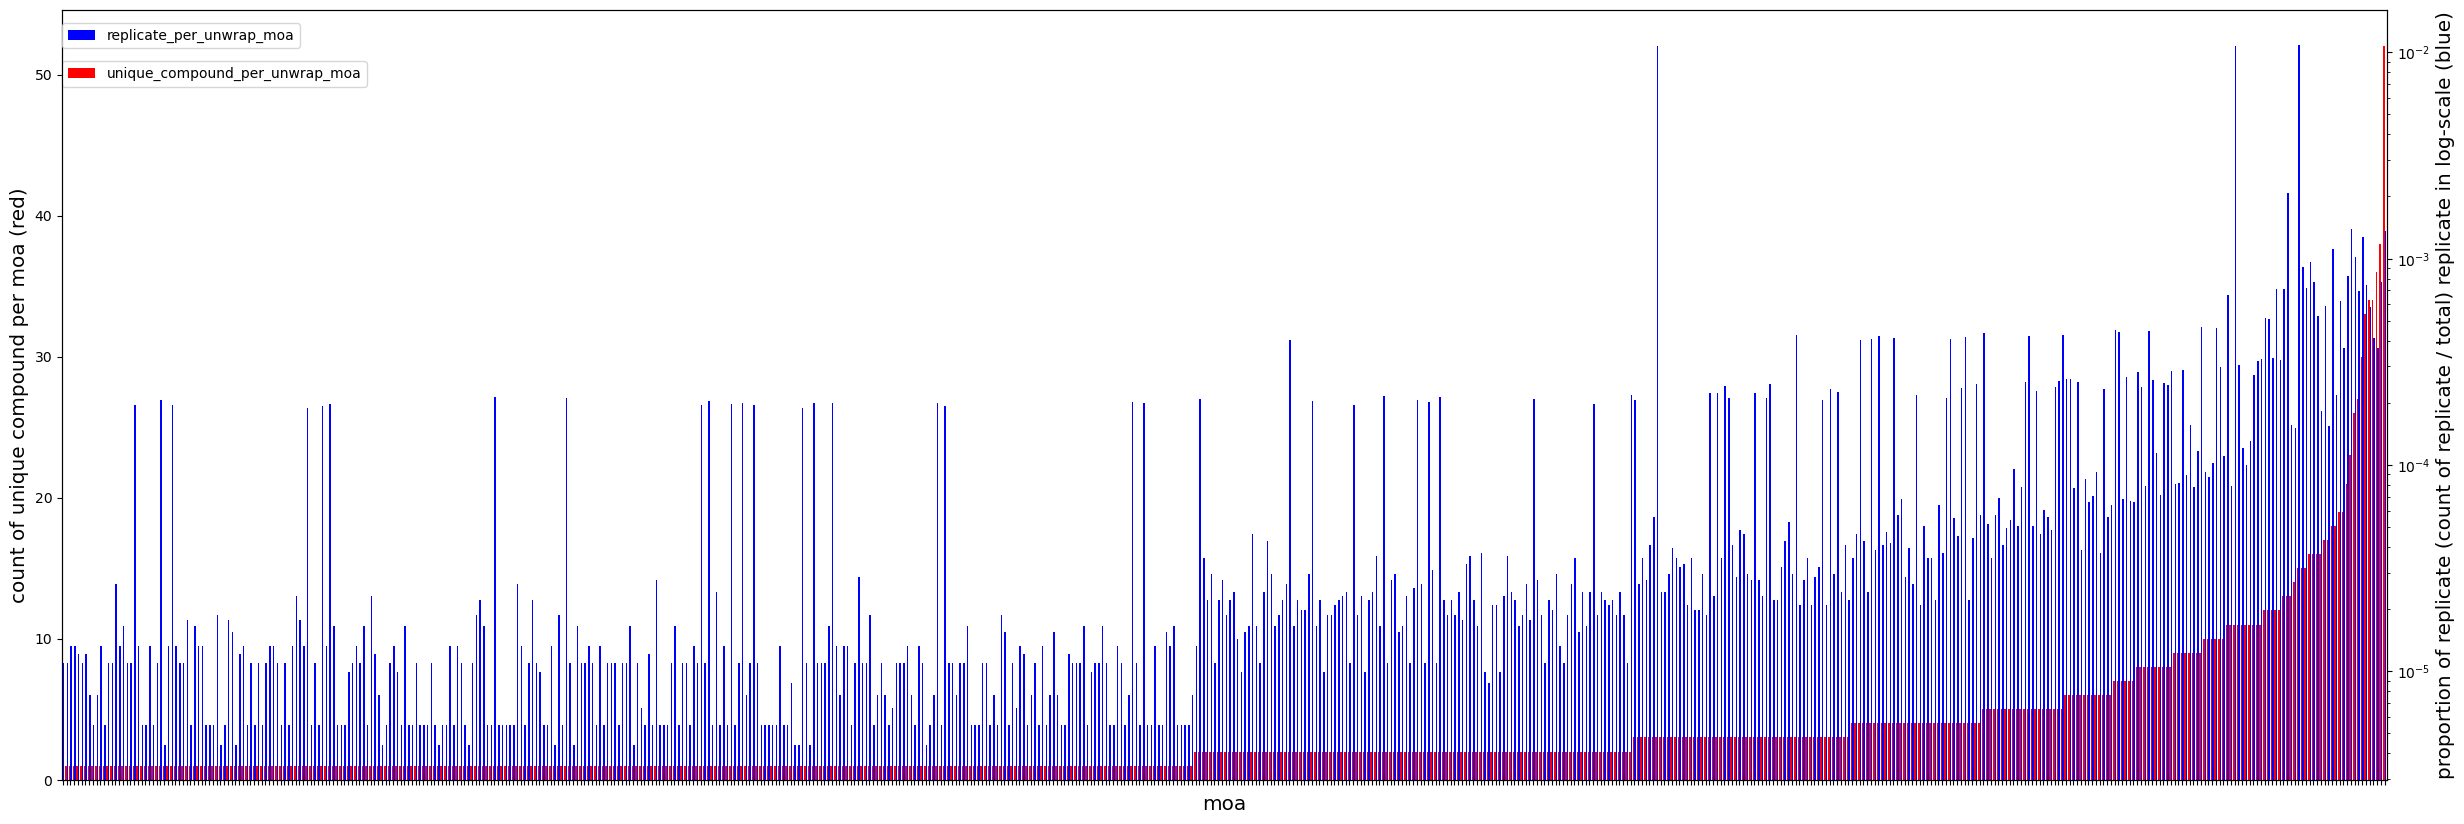

In [340]:
show_key_distribution(compound_count_per_unwrap_moa, total_replicate)

In [341]:
compound_count_per_target.select(pl.all().exclude("target")).describe()

describe,unique_compound_per_target,replicate_per_target
str,f64,f64
"""count""",2591.0,2591.0
"""null_count""",0.0,0.0
"""mean""",1.189502,87.842146
"""std""",0.906424,2746.69268
"""min""",1.0,3.0
"""25%""",1.0,5.0
"""50%""",1.0,10.0
"""75%""",1.0,15.0
"""max""",19.0,138936.0


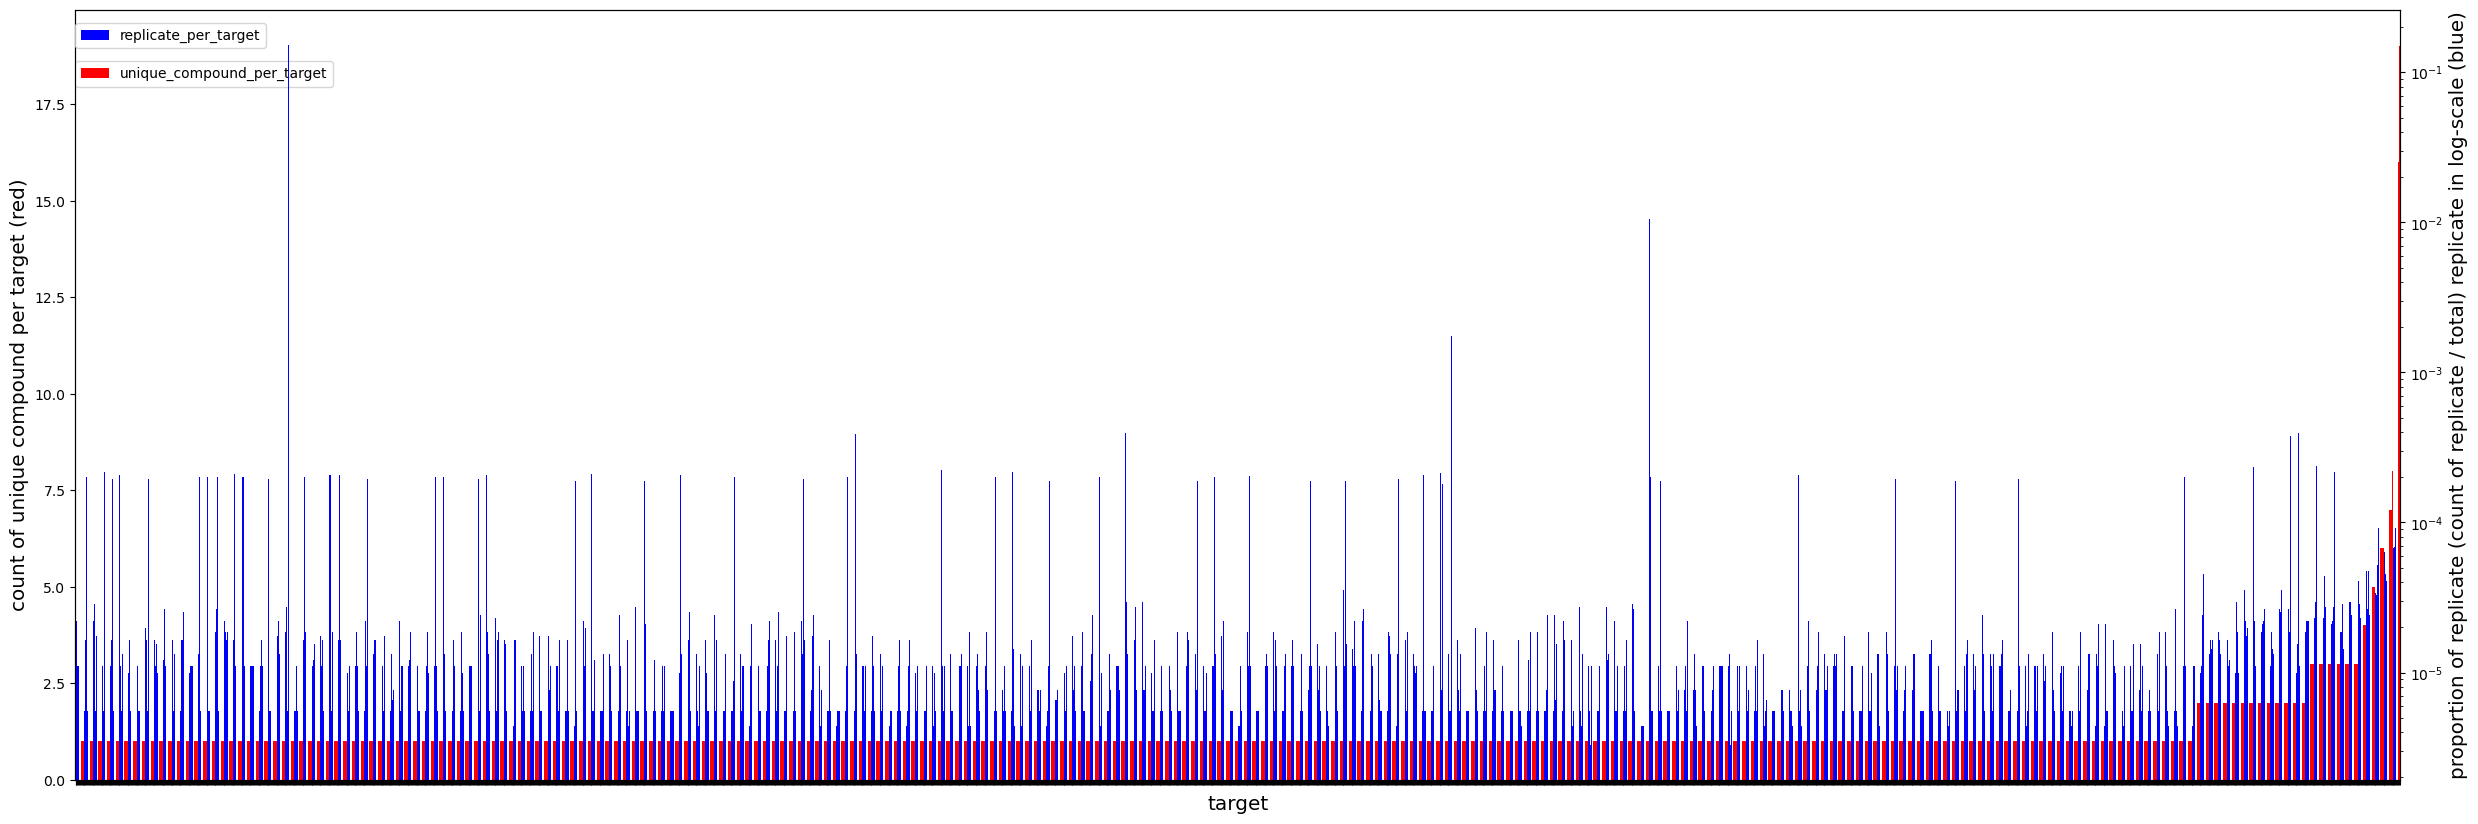

In [342]:
show_key_distribution(compound_count_per_target, total_replicate)

In [343]:
compound_count_per_unwrap_target.select(pl.all().exclude("target")).describe()

describe,unique_compound_per_unwrap_target,replicate_per_unwrap_target
str,f64,f64
"""count""",20368.0,20368.0
"""null_count""",0.0,0.0
"""mean""",6.976385,2414.604527
"""std""",12.322709,17615.878206
"""min""",1.0,4.0
"""25%""",2.0,25.0
"""50%""",4.0,52.0
"""75%""",7.0,212.0
"""max""",541.0,150987.0


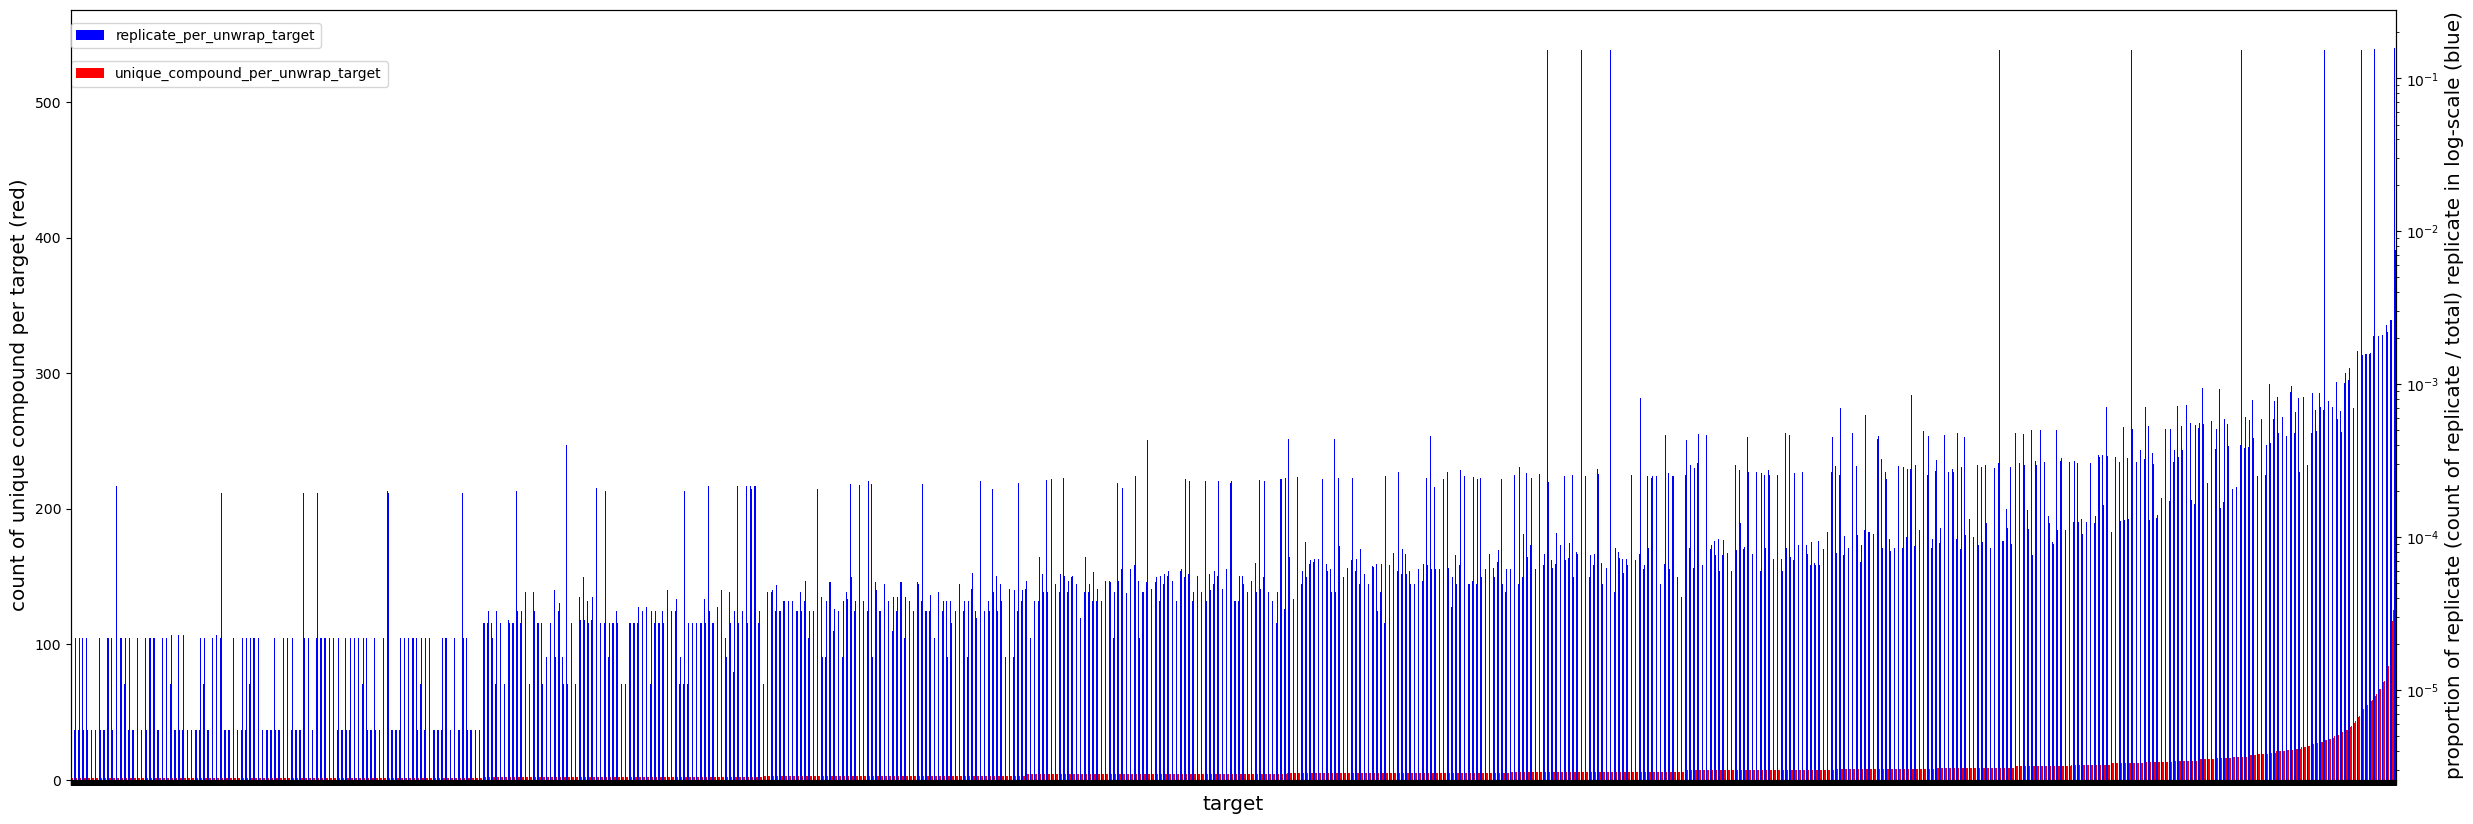

In [344]:
show_key_distribution(compound_count_per_unwrap_target, total_replicate)

## b) Other visualisation easier

#### How to interpret this graph:
Here we simply compare the number of moa/target (y-axis, frequency) having a certain number of perturbation (x-axis)

In [474]:
def histogram(table1, table2):
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes.flatten()

    for i in range(2):
        if i==0: 
            group, unique, replicate = table1.columns
            df = (table1.sort(by=[unique, group])).to_pandas()
            c="red"
        else:
            group, unique, replicate = table2.columns
            df = (table2.sort(by=[unique, group])).to_pandas()
            c="blue"
        df[unique].plot.hist(bins=50, color=c, ax=axes[i], label=group)

        axes[i].legend(loc=(0.85,0.95))
        axes[i].set_ylim(0,200)
        axes[i].set_xlabel(f'count of unique compound per {group}', fontsize="x-large")
        axes[i].set_ylabel("Frequency" if i == 0 else "", fontsize="x-large")

### i) comparison of moa distribution vs target distribution

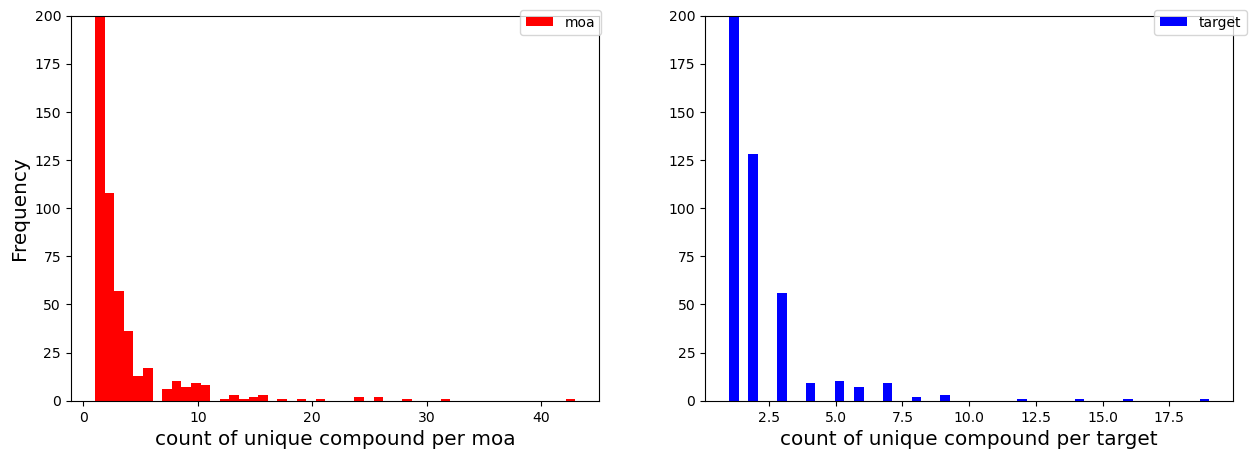

In [475]:
histogram(compound_count_per_moa, compound_count_per_target)

### ii) comparison of moa distribution vs target distribution - when unwrap

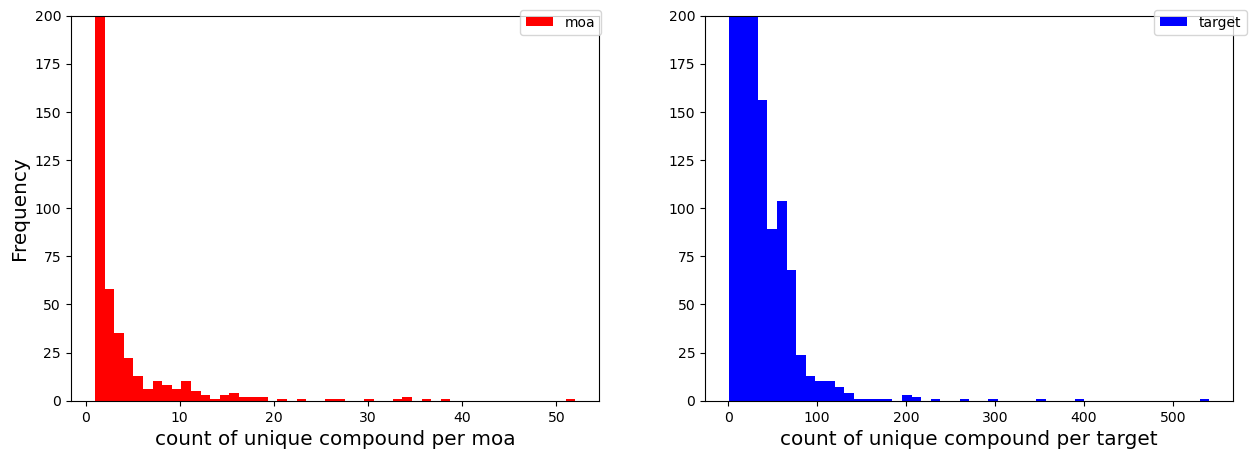

In [477]:
histogram(compound_count_per_unwrap_moa, compound_count_per_unwrap_target)